# Assignment 2 (William Cromar)

Complete dataset (data.csv) includes residential, single family homes in Orange County FL, from the past three years (as of March 15, 2017). Sales less than $100 dollars have been excluded from the dataset.

Data was queried from the Orange County Property Appraiser's website, using the Sales Search utility. (Link: http://www.ocpafl.org/searches/ParcelSearch.aspx)

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

## Data

This is where Python really shines. I'll import the data from a csv, eliminate some data points to narrow the scope of this analysis, and munge the data a little bit into a format that I can use.

In [2]:
# Read in the data from the CSV
data_raw = pd.read_csv("data.csv")

# Only include sales of type "SALE QUALIFIED AS RESULT OF DEED EXAMINATION" (code 1)
data_raw = data_raw[data_raw["SaleDescriptionCode"] == 1]

# Pull the year out of each year's time stamp
# Time stamps follow the form MM/DD/YYYY HH:MM:SS
data_raw["Year Sold"] = data_raw["Date of Sale"].map(lambda timestamp: int(timestamp.split(" ")[0].split("/")[2]))

# I'm also going to drop datapoints that have an average year built after they were sold
# ie building plans that were sold
data_raw = data_raw[data_raw["Average Year Built"] <= data_raw["Year Sold"]]

# Determine the house's age at the time of sale
data_raw["Age at Sale"] = data_raw["Year Sold"] - data_raw["Average Year Built"]

In [3]:
# Extract useful data from data_raw
data = pd.DataFrame()
data["VALUE"] = data_raw["Sale Amount"]
data["BED"] = data_raw["Bedrooms"]
data["BATH"] = data_raw["Bathrooms"]
data["AREA"] = data_raw["Heated Area"]
data["AGE"] = data_raw["Age at Sale"]
data["TYPE"] = data_raw["Property Use Type"]

print data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6197 entries, 0 to 9999
Data columns (total 6 columns):
VALUE    6197 non-null int64
BED      6197 non-null int64
BATH     6197 non-null float64
AREA     6197 non-null int64
AGE      6197 non-null int64
TYPE     6197 non-null object
dtypes: float64(1), int64(4), object(1)
memory usage: 338.9+ KB
None


## Visualizations

Let's try to visualize the interactions between variables.

### Relationships between numerical variables

Next up, let's visualize the relationships between the numerical variables in the dataset.

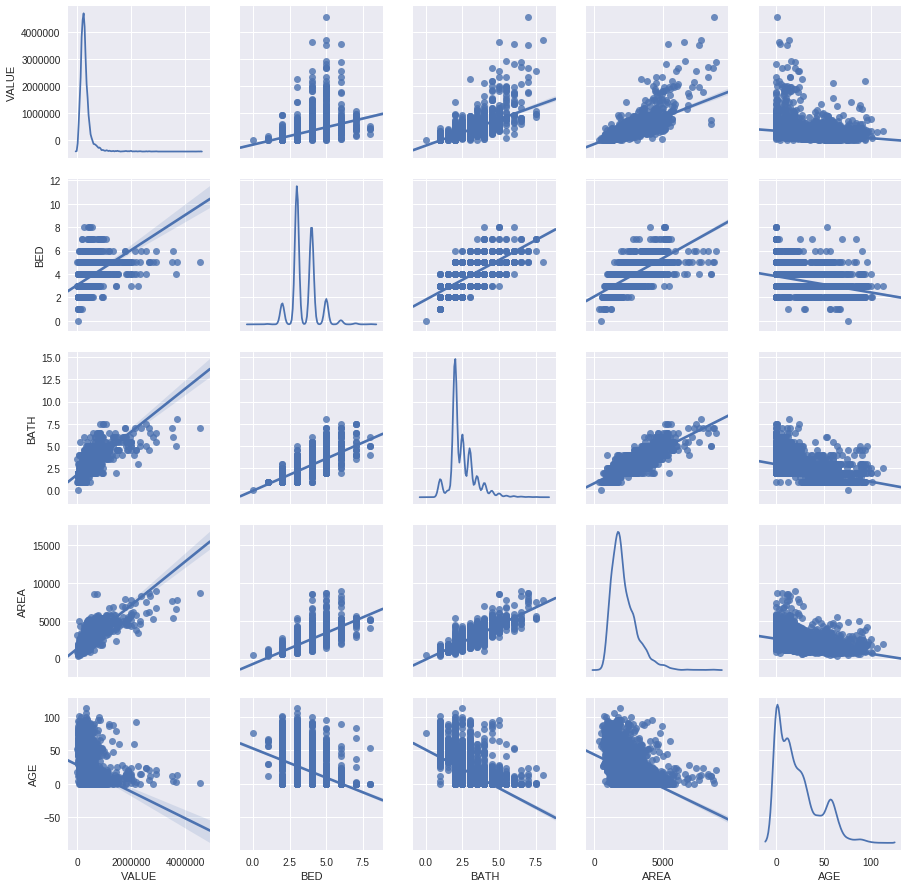

In [4]:
sns.pairplot(data=data.drop(["TYPE"], axis=1), kind="reg", diag_kind="kde")

Here are some quick observations:
1. Looking at the top row, value seems to most strongly correlated with heated area, but also seems to be somewhat correlated with the number of bedrooms and bathrooms, respectively. Value seems to be mostly uncorrelated with the age of the house at the time of its sale.
2. There are strong co-linearities between independent variables. Particularly, the number of bedrooms and bathrooms seems to be quite co-linear with the heated area of the house. This makes sense: adding a room to house will add to its interior area.

### Nominal Variable: Type

Next, let's see if the nominal variable (home type) has any significant impact on the value of that home.

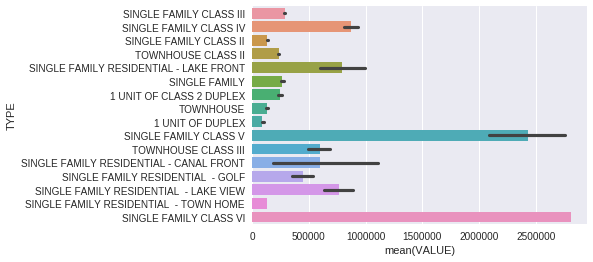

In [5]:
sns.barplot(x="VALUE", y="TYPE", data=data)

There appear to be several classes that are quite close to each other (eg single family and townhouse class II) and and two classes that only have one sample (in particular, single family residential adn single family class VI). I'm hesitant to include type as an independent variable at the moment, since the model will overfit to the smaller types, especially the ones with only one sample.

A possible solution might be to employ cluster analysis on the mean values of each house type.

TYPE
1 UNIT OF CLASS 2 DUPLEX                   2.442652e+05
1 UNIT OF DUPLEX                           9.276364e+04
SINGLE FAMILY                              2.684957e+05
SINGLE FAMILY CLASS II                     1.349991e+05
SINGLE FAMILY CLASS III                    2.890403e+05
SINGLE FAMILY CLASS IV                     8.710197e+05
SINGLE FAMILY CLASS V                      2.428392e+06
SINGLE FAMILY CLASS VI                     2.806500e+06
SINGLE FAMILY RESIDENTIAL  - GOLF          4.465000e+05
SINGLE FAMILY RESIDENTIAL  - LAKE VIEW     7.642500e+05
SINGLE FAMILY RESIDENTIAL  - TOWN HOME     1.300000e+05
SINGLE FAMILY RESIDENTIAL - CANAL FRONT    6.019800e+05
SINGLE FAMILY RESIDENTIAL - LAKE FRONT     7.885806e+05
TOWNHOUSE                                  1.293362e+05
TOWNHOUSE CLASS II                         2.350485e+05
TOWNHOUSE CLASS III                        5.948500e+05
Name: VALUE, dtype: float64


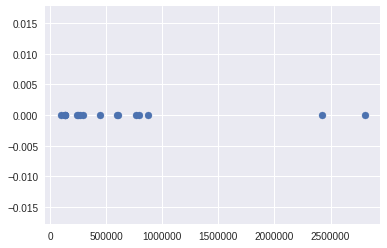

In [6]:
# Find the mean value of each type
tmeans = data.groupby(["TYPE"]).mean()["VALUE"]
print tmeans

# Plot the means on the number line
plt.scatter(tmeans.as_matrix(), np.zeros(len(tmeans)))

To my eyes, there appear to be about four clusters of points. I'll use sklearn for the cluster analysis.

TYPE
1 UNIT OF CLASS 2 DUPLEX                   2
1 UNIT OF DUPLEX                           2
SINGLE FAMILY                              2
SINGLE FAMILY CLASS II                     2
SINGLE FAMILY CLASS III                    2
SINGLE FAMILY CLASS IV                     3
SINGLE FAMILY CLASS V                      1
SINGLE FAMILY CLASS VI                     1
SINGLE FAMILY RESIDENTIAL  - GOLF          0
SINGLE FAMILY RESIDENTIAL  - LAKE VIEW     3
SINGLE FAMILY RESIDENTIAL  - TOWN HOME     2
SINGLE FAMILY RESIDENTIAL - CANAL FRONT    0
SINGLE FAMILY RESIDENTIAL - LAKE FRONT     3
TOWNHOUSE                                  2
TOWNHOUSE CLASS II                         2
TOWNHOUSE CLASS III                        0
Name: VALUE, dtype: int64


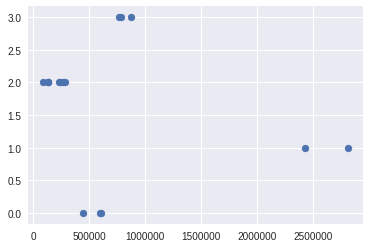

In [7]:
from sklearn.cluster import KMeans

# Initialize KMeans with 4 cluster centers
clf = KMeans(n_clusters=4, random_state=42)

# Fit clf to the means
clf.fit(tmeans.as_matrix().reshape(-1, 1))

# Assign each type to one of the four clusters
# Note: sklean gives a list for cluster predictions, so I'll go through and pull
# out the first element of each list
clusters = tmeans.map(clf.predict).map(lambda lst: lst[0])
print clusters

# Visualize clustering
# Each horizontal level represents a distinct cluster
plt.scatter(tmeans.as_matrix(), clusters.as_matrix())

In [8]:
# Looks good! Next, I'll add the cluster designation as a feature called "group"
data["GROUP"] = data["TYPE"].map(clusters.get)
# Mean price for each group
print data.groupby("GROUP").mean()["VALUE"]

GROUP
0    5.576667e+05
1    2.443516e+06
2    2.574991e+05
3    8.576012e+05
Name: VALUE, dtype: float64


## Model

Now that I have all of my variables set up, it's time to start building the model.


### Minimal model

I'll start with the most basic model: a linear regression between home sale price and heated area.
I will also test the null hypothesis that there is no correlation between the two variables.

In [9]:
from statsmodels.formula.api import ols

model_min = ols("VALUE ~ AREA", data=data).fit()
print model_min.summary()

                            OLS Regression Results                            
Dep. Variable:                  VALUE   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     7992.
Date:                Sun, 19 Mar 2017   Prob (F-statistic):               0.00
Time:                        16:10:14   Log-Likelihood:                -83242.
No. Observations:                6197   AIC:                         1.665e+05
Df Residuals:                    6195   BIC:                         1.665e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -1.35e+05   5211.224    -25.903      0.0

The p-value of the F statistic is below 0.00, which is less than my stated alpha of .05. Thus, I can reject the null hypothesis that heated area and home value are uncorrelated.

Looking at the parameters, it seems that every additional square foot of heated area adds about $196 to a home's value. The intercept is meaningless in this context, since it's outside of the range of the data.

Here's what the model looks like:

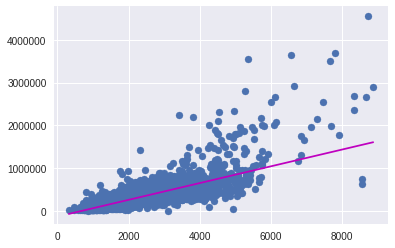

In [10]:
plt.scatter(data["AREA"], data["VALUE"])
inter, slope = model_min.params
pts = np.array([data["AREA"].min(), data["AREA"].max()])
pred = inter + slope * pts
plt.plot(pts, pred, color='m')

### Adding rooms to the model

Next, I'll include information on how many rooms are in the home. I'll use the partial F test to test the null hypothesis that room information does not contribute significant predictive value.

In [11]:
model_rooms = ols("VALUE ~ AREA + BED + BATH", data=data).fit()
print model_rooms.summary()

                            OLS Regression Results                            
Dep. Variable:                  VALUE   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     3219.
Date:                Sun, 19 Mar 2017   Prob (F-statistic):               0.00
Time:                        16:10:14   Log-Likelihood:                -82897.
No. Observations:                6197   AIC:                         1.658e+05
Df Residuals:                    6193   BIC:                         1.658e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -1.872e+04   8861.854     -2.112      0.0

The new variables slightly increased the R^2 value, but these results are strange -- according to the model, adding bedrooms to an existing house decreases its value by $8,469. This is clearly false. This issue is likely due to BATH's co-linearity with AREA.

Below is the F test comparing this model to the last one:

(I'll write the test as a function, so I can use it later on)

In [12]:
from statsmodels.stats.anova import anova_lm

def partialF(model_red, model_com):
    # Run ANOVA to find the SSE/RSS
    anova_red = anova_lm(model_red)
    anova_com = anova_lm(model_com)

    RSS_red = anova_red["sum_sq"]["Residual"]
    RSS_com = anova_com["sum_sq"]["Residual"]

    # Number of samples and DF of complete model, respectively
    n = len(data)
    k = model_com.df_model

    # Degrees of freedom for numerator and denominator
    dfn = k - model_red.df_model
    dfd = (n - k - 1)

    # Calculate the F statistic and p-value
    numer = (RSS_red - RSS_com) / dfn
    denom = RSS_com / dfd
    F = numer / denom
    p_value = 1 - sp.stats.f.cdf(F, dfn, dfd)
    
    return F, p_value

F, p_value = partialF(model_min, model_rooms)
print "F-statistic:", F 
print "p-value:", p_value

F-statistic: 363.772786227
p-value: 1.11022302463e-16


/home/will/tools/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/will/tools/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/will/tools/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


The partial F test yields quite a significant test statistic -- the p-value is on the order of 10^-16, which is far below my alpha. Thus, I can reject the null hypothesis that including BED and BATH gives no predictive value, despite the odd parameter estimates.

### Including age in the model

Next, I will test the null hypothesis that a house's age at the time of sale yields no significant predictive value. I'll use the same partial F test function to test the validity of the new parameter.

In [13]:
model_age = ols("VALUE ~ AREA + BED + BATH + AGE", data=data).fit()
print model_age.summary()

                            OLS Regression Results                            
Dep. Variable:                  VALUE   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     2610.
Date:                Sun, 19 Mar 2017   Prob (F-statistic):               0.00
Time:                        16:10:14   Log-Likelihood:                -82748.
No. Observations:                6197   AIC:                         1.655e+05
Df Residuals:                    6192   BIC:                         1.655e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -1.092e+05   1.01e+04    -10.834      0.0

It seems that additional years of age, in general add quite a bit of value to a house, with the parameter estimate being an increase in $1,806 per one year increase in age. Now, for the partial F test of the AGE parameter:

In [14]:
F, p_value = partialF(model_rooms, model_age)
print "F statistic:", F
print "p-value:", p_value

F statistic: 306.24143148
p-value: 1.11022302463e-16


The p-value for the partial F test statistic is on the order of 10^-16, far below my alpha of .05. Thus, I can reject the null hypothesis that a home's at at the time of its sale has little predictive value for its sale value.

### Including house type in the model

Finally, it's time to test the last independent variable: house type. Recall that I have used cluster analysis to combine the house type assignments into 4 groups, which I will treat as a nominal variable.

Again, I'll use my partialF function to determine if the new variable has any significant predictive value.

In [15]:
# Add terms for each group type in the model
data["G0"] = data["GROUP"] == 0
data["G1"] = data["GROUP"] == 1
data["G2"] = data["GROUP"] == 2
data["G3"] = data["GROUP"] == 3

model_type = ols("VALUE ~ AREA + BED + BATH + AGE + G0 + G1 + G2 + G3", data=data).fit()
print model_type.summary()

                            OLS Regression Results                            
Dep. Variable:                  VALUE   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     3703.
Date:                Sun, 19 Mar 2017   Prob (F-statistic):               0.00
Time:                        16:10:14   Log-Likelihood:                -80708.
No. Observations:                6197   AIC:                         1.614e+05
Df Residuals:                    6189   BIC:                         1.615e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     3.9e+05      1e+04     38.823      0.0

In [16]:
F, p_value = partialF(model_age, model_type)
print "F statistic:", F
print "p-value:", p_value

F statistic: 1922.36129363
p-value: 1.11022302463e-16


The partial F test yielded a huge test statistic which falls far my below my stated alpha. Thus, I can reject the null hypothesis that house type has not significant impact on that house's value. In fact, it seems to be one of the most predictive variables that I have added.

Write some more notes about the new intercepts for each house group.

## Conclusion and analysis

Write this later